In [1]:
### JUPYTER NOTEBOOK / MODULE PATH FIX ###
import sys

if "/share/apps/python/3.8.6/intel/lib/python3.8" in sys.path and sys.path[1] == '':
    sys.path[1], sys.path[6] = sys.path[6], sys.path[1]

In [2]:
from jtb_2022_code.utils.figure_data import FigureSingleCellData
from jtb_2022_code.figure_constants import *
from jtb_2022_code.utils.figure_common import *
from jtb_2022_code.utils.model_result_loader import load_model_results, summarize_model_results


/home/cj59/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/cj59/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/cj59/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/cj59/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


2023-07-12 15:27:31 2 Preprocessing methods selected: Predictor method zscore [limit 10] Response method zscore [limit 10] Pre-TFA expression method robustscaler [limit 20] 


In [3]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import torch

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.patches as patches

from torch.utils.data import DataLoader
from sklearn.preprocessing import RobustScaler
from inferelator_velocity.utils.aggregation import aggregate_sliding_window_times

from supirfactor_dynamical import (
    read,
    TimeDataset,
    TruncRobustScaler
)

from sklearn.model_selection import train_test_split

In [4]:
data = FigureSingleCellData()
fit_model = read(SUPIRFACTOR_VELOCITY_STATIC_MODEL).eval()

velo_data = ad.AnnData(np.vstack((
    data.decay_data(1, "WT").layers[f"rapamycin_velocity"],
    data.decay_data(2, "WT").layers[f"rapamycin_velocity"]
)))
velo_data.var_names = data.all_data.var_names.copy()
velo_data = velo_data[:, fit_model.prior_network_labels[0]].copy()

model_data = ad.AnnData(data.all_data.layers['counts'][data.all_data.obs['Gene'] == "WT", :].astype(np.float32))
model_data.obs = data.all_data.obs.loc[data.all_data.obs['Gene'] == "WT", :].copy()
model_data.obs['program_rapa_time'] = model_data.obs['program_1_time']
model_data.var = data.all_data.var.copy()
model_data = model_data[:, fit_model.prior_network_labels[0]].copy()
sc.pp.normalize_per_cell(model_data, counts_per_cell_after=3099)

_, test_idx = train_test_split(
    np.arange(model_data.shape[0]),
    test_size=0.25,
    random_state=1800
)

data_scaler = TruncRobustScaler(with_centering=False)
model_data.layers['scaled'] = data_scaler.fit_transform(model_data.X)

velo_scaler = TruncRobustScaler(with_centering=False)
velo_data.layers['scaled'] = velo_scaler.fit_transform(velo_data.X)

velo_data.obs_names = model_data.obs_names.copy()
velo_data.obs = model_data.obs.copy()

data._unload()

with torch.no_grad():
    predicts_training = fit_model(
        torch.tensor(model_data.layers['scaled'][test_idx, :].A),
    )
    predicts_training = velo_scaler.inverse_transform(predicts_training.numpy())

predicts_training = ad.AnnData(predicts_training)
predicts_training.var_names = model_data.var_names.copy()
predicts_training.obs = model_data.obs.iloc[test_idx, :].copy()

Reading Single Cell Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_1_WT.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_1_fpr1.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_2_WT.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_2_fpr1.h5ad
Loading velocity data from /scratch/cj59/RAPA/2021_RAPA_VELOCITY_FIGS_1_WT.h5ad
Loading velocity data from /scratch/cj59/RAPA/2021_RAPA_VELOCITY_FIGS_2_WT.h5ad


In [5]:
results, _ = load_model_results("Velocity")
summary_results, summary_stats = summarize_model_results(results, "Velocity")

In [10]:
summary_results

,Learning_Rate,Weight_Decay,Seed,Output_Layer_Time_Offset,Epochs,Model_Type,Time_Axis,AUPR,F1,MCC,...,Pretrained_Model,Layer,Input_Dropout,Hidden_Layer_Dropout,Velocity,Decay,model,Shuffle,x_loc,x_color
2582,0.00005,1.000000e-07,111,10,200.0,rnn,combined,0.038389,0.104987,0.092296,...,False,X,0.5,0.0,True,False,rnn_predictive,False,12.5,#e7298a
2585,0.00005,1.000000e-07,112,10,200.0,rnn,combined,0.023351,0.070012,0.054439,...,False,X,0.5,0.0,True,False,rnn_predictive,False,12.5,#e7298a
2588,0.00005,1.000000e-07,113,10,200.0,rnn,combined,0.056048,0.084951,0.127537,...,False,X,0.5,0.0,True,False,rnn_predictive,False,12.5,#e7298a
2591,0.00005,1.000000e-07,114,10,200.0,rnn,combined,0.034824,0.093313,0.089787,...,False,X,0.5,0.0,True,False,rnn_predictive,False,12.5,#e7298a
2594,0.00005,1.000000e-07,115,10,200.0,rnn,combined,0.046897,0.075221,0.132002,...,False,X,0.5,0.0,True,False,rnn_predictive,False,12.5,#e7298a
2597,0.00005,1.000000e-07,116,10,200.0,rnn,combined,0.043583,0.104405,0.109451,...,False,X,0.5,0.0,True,False,rnn_predictive,False,12.5,#e7298a
2600,0.00005,1.000000e-07,117,10,200.0,rnn,combined,0.042493,0.100763,0.092766,...,False,X,0.5,0.0,True,False,rnn_predictive,False,12.5,#e7298a
2603,0.00005,1.000000e-07,118,10,200.0,rnn,combined,0.029542,0.088000,0.083274,...,False,X,0.5,0.0,True,False,rnn_predictive,False,12.5,#e7298a
2606,0.00005,1.000000e-07,119,10,200.0,rnn,combined,0.038696,0.074534,0.134002,...,False,X,0.5,0.0,True,False,rnn_predictive,False,12.5,#e7298a
2609,0.00005,1.000000e-07,120,10,200.0,rnn,combined,0.032468,0.091892,0.079376,...,False,X,0.5,0.0,True,False,rnn_predictive,False,12.5,#e7298a


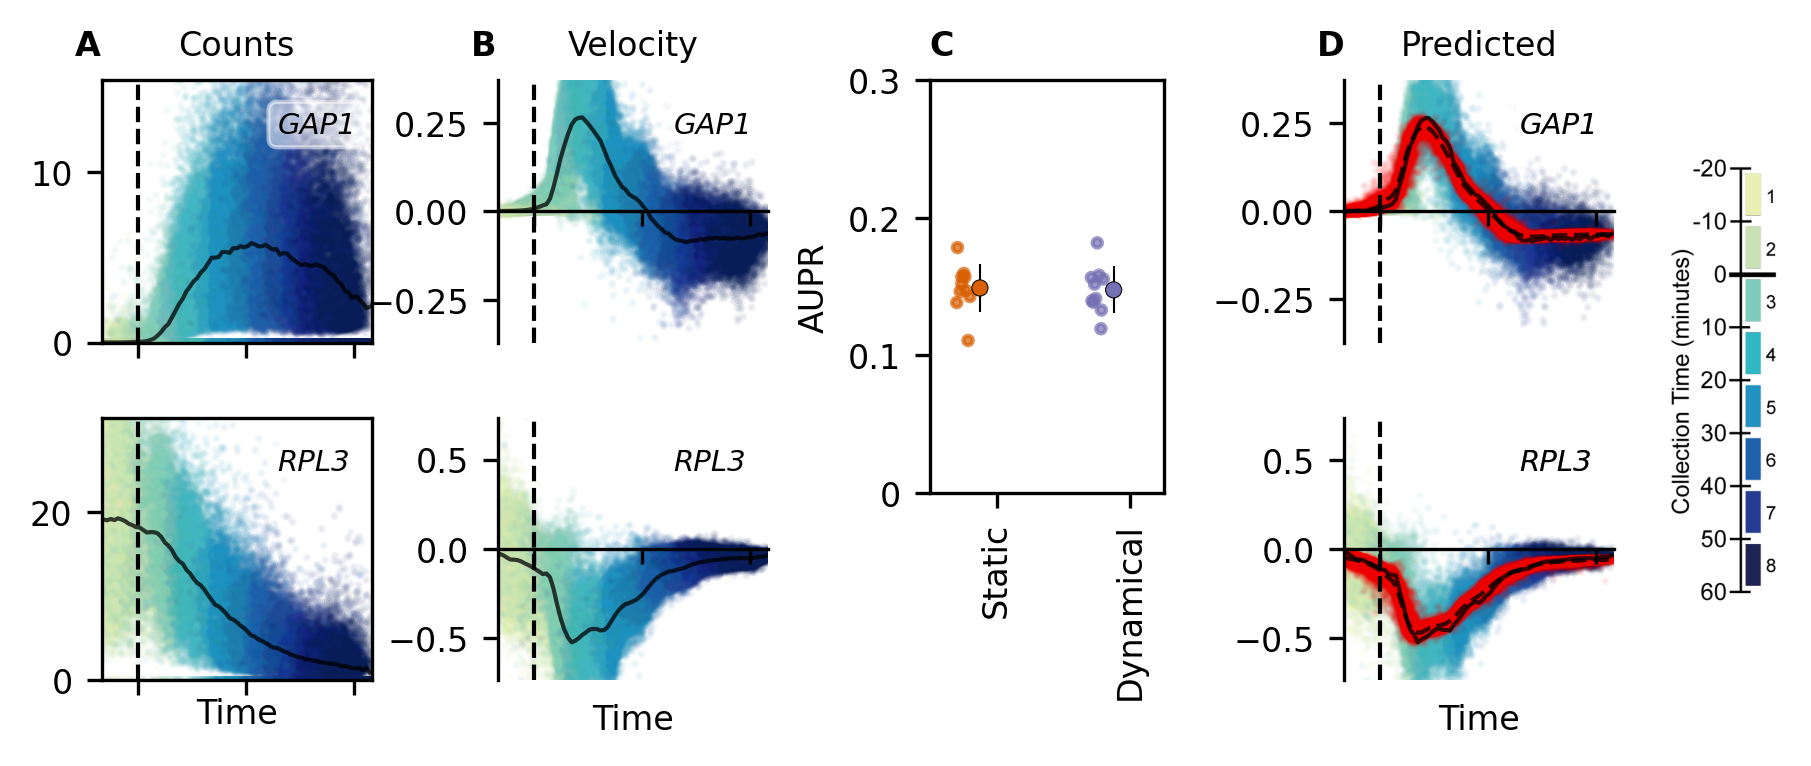

In [26]:
fig_refs = {}
fig = plt.figure(figsize=(6, 2.5), dpi=MAIN_FIGURE_DPI)

rng = np.random.default_rng(100)

_height = 0.37
_width = 0.25

axd = {
    'gene_1_expr': fig.add_axes([0.05, 0.55, 0.15, 0.35]),
    'gene_2_expr': fig.add_axes([0.05, 0.1, 0.15, 0.35]),
    'gene_1_velo': fig.add_axes([0.27, 0.55, 0.15, 0.35]),
    'gene_2_velo': fig.add_axes([0.27, 0.1, 0.15, 0.35]),    
    'results': fig.add_axes([0.51, 0.35, 0.13, 0.55]),
    'gene_1_predicts': fig.add_axes([0.74, 0.55, 0.15, 0.35]),
    'gene_2_predicts': fig.add_axes([0.74, 0.1, 0.15, 0.35]),
    'legend': fig.add_axes([0.9, 0.2, 0.1, 0.6])
}


def plot_gene(d, gene, ax, rgen, velocity=False, predicts=False):
       
    overplot_shuffle = np.arange(d.shape[0])
    rgen.shuffle(overplot_shuffle)
    
    _time = d.obs['program_rapa_time'].values
    
    if predicts:
        _color = np.array(['red'] * d.shape[0])
    else:
        _color = to_pool_colors(d.obs['Pool']).astype(str)
   
    _gene_data = d.X[:, d.var_names.get_loc(g)]
    
    try:
        _gene_data = _gene_data.A
    except AttributeError:
        pass
    
    _gene_data = _gene_data.ravel()

    ax.scatter(
        x=_time[overplot_shuffle], 
        y=_gene_data[overplot_shuffle],
        c=_color[overplot_shuffle],
        alpha=0.05, 
        s=1
    )
    
    ax.annotate(
        data.gene_common_name(gene),
        (0.65, 0.8),
        xycoords='axes fraction',
        color='black',
        size=7,
        fontstyle='italic',
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='white', boxstyle='round')
    )

    median_counts, _window_centers = aggregate_sliding_window_times(
        _gene_data.reshape(-1, 1),
        _time,
        centers=np.linspace(-10 + 0.5, 65 - 0.5, 75),
        width=1.
    )

    ax.plot(
        _window_centers, 
        median_counts,
        c='black',
        alpha=0.75,
        linewidth=1.0,
        linestyle='solid' if not predicts else 'dashed',
        zorder=2
    )

    ax.set_xlim(-10, 65)
    ax.set_xticks([0, 30, 60], [])
    
    if predicts:
        pass
    elif velocity:
        _ylim = np.quantile(np.abs(_gene_data), 0.995)
        ax.set_ylim(-1 * _ylim, _ylim)
        velocity_axes(ax)
    else:
        ax.set_ylim(0, np.quantile(_gene_data, 0.995))
    
    if not predicts:
        ax.axvline(0, 0, 1, linestyle='--', linewidth=1.0, c='black')

    ax.tick_params(axis='both', which='major', labelsize=8)

    
rgen = np.random.default_rng(441)
for i, g in enumerate(["YKR039W", "YOR063W"]):
            
    plot_gene(model_data, g, axd[f"gene_{i + 1}_expr"], rgen, velocity=False)
    plot_gene(velo_data, g, axd[f"gene_{i + 1}_velo"], rgen, velocity=True)
    
    plot_gene(velo_data[test_idx, :], g, axd[f"gene_{i + 1}_predicts"], rgen, velocity=True)
    plot_gene(predicts_training, g, axd[f"gene_{i + 1}_predicts"], rgen, predicts=True)

axd[f"gene_1_expr"].set_title("Counts", size=8)
axd[f"gene_1_expr"].set_title("A", loc='left', weight='bold', size=8, x=-0.1)
axd[f"gene_1_velo"].set_title("Velocity", size=8)
axd[f"gene_1_velo"].set_title("B", loc='left', weight='bold', size=8, x=-0.1)
axd[f"gene_1_predicts"].set_title("Predicted", size=8)
axd[f"gene_1_predicts"].set_title("D", loc='left', weight='bold', size=8, x=-0.1)
axd[f"results"].set_title("C", loc='left', weight='bold', size=8)

axd[f"gene_2_expr"].set_xlabel("Time", size=8, labelpad=-3)
axd[f"gene_2_velo"].set_xlabel("Time", size=8, labelpad=30)
axd[f"gene_2_predicts"].set_xlabel("Time", size=8, labelpad=30)
    
axd['results'].scatter(
    summary_results['x_loc'] + rng.uniform(-0.2, 0.2, summary_results.shape[0]),
    summary_results['AUPR'],
    color=summary_results['x_color'],
    s=5,
    alpha=0.7
)

axd['results'].scatter(
    summary_stats['x_loc'] + 0.5,
    summary_stats['mean'],
    color=summary_stats['x_color'],
    s=15,
    edgecolor='black',
    linewidth=0.25,
    alpha=1
)

axd['results'].errorbar(
    summary_stats['x_loc'] + 0.5,
    summary_stats['mean'],
    yerr=summary_stats['std'],
    fmt='none',
    color='black',
    alpha=1,
    linewidth=0.5,
    zorder=-1
)

axd['results'].set_ylim(0, 0.3)
axd['results'].set_xlim(3.5, 10.5)
axd['results'].set_ylabel("AUPR", size=8)
axd['results'].set_yticks([0, 0.1, 0.2, 0.3], [0, 0.1, 0.2, 0.3], size=8)
axd['results'].set_xticks([5.5, 9.5], ['Static', 'Dynamical'], size=7, rotation=90)
axd['results'].tick_params(axis='both', which='major', labelsize=8)

axd['legend'].imshow(plt.imread(FIG_RAPA_LEGEND_VERTICAL_FILE_NAME), aspect='equal')
axd['legend'].axis('off')

fig.savefig("figures/Figure_4.png", facecolor="white")